In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
# Step 1: Install and Import Dependencies
!pip install segmentation-models-pytorch
!pip install torch torchvision

In [21]:
import torch
import segmentation_models_pytorch as smp
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import tifffile as tiff
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np

In [22]:
# Step 2: Define Dataset Class Using tifffile for .tif images and PIL for .png masks
class TiffPngSegmentationDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.images[idx])
        mask_name = self.images[idx].replace('.tif', '.png')  # Assuming corresponding mask has the same name but .png extension
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = tiff.imread(img_path)
        mask = Image.open(mask_path).convert("L")

        # Convert to 3-channel image if necessary
        if len(image.shape) == 2:
            image = np.stack([image] * 3, axis=-1)  # Grayscale to RGB-like format

        # Convert image to tensor
        image = torch.tensor(image, dtype=torch.float32).permute(2, 0, 1)  # HWC to CHW

        # Convert mask to tensor
        mask = torch.tensor(np.array(mask), dtype=torch.float32).unsqueeze(0)  # Add channel dimension for the mask

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask


In [23]:
# Step 3: Define Transformations and Load Dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
])

# Update with the correct path to your data in Colab
train_dataset = TiffPngSegmentationDataset(images_dir= '/content/drive/MyDrive/Data/data/images', masks_dir= '/content/drive/MyDrive/Data/data/labels', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [25]:
# Step 4: Load Pretrained U-Net Model
model = smp.Unet(
    encoder_name="resnet34",        # Choose encoder: resnet34, resnet50, etc.
    encoder_weights="imagenet",     # Use pretrained weights on ImageNet
    in_channels=12,                  # Input channels (RGB images)
    classes=1,                      # Output classes (1 for binary segmentation)
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(12, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, trac

In [28]:
# Step 5: Define Loss, Optimizer, and Accuracy Function
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Step 5: Corrected Accuracy Function
def accuracy(preds, labels):
    preds = torch.sigmoid(preds)  # Apply sigmoid to get probabilities
    preds = (preds > 0.5).float()  # Convert probabilities to binary predictions (0 or 1)

    correct = (preds == labels).float()  # Check for equality, returns 1 where equal and 0 otherwise
    acc = correct.sum() / correct.numel()  # Divide by total number of elements (pixels)
    return acc


In [29]:
# Step 6: Training Loop with Accuracy and Loss Tracking
num_epochs = 10
train_loss = []
train_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        running_loss += loss.item()
        running_acc += accuracy(outputs, masks).item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = running_acc / len(train_loader)
    train_loss.append(epoch_loss)
    train_accuracy.append(epoch_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch [1/10], Loss: 0.3136, Accuracy: 0.8829
Epoch [2/10], Loss: 0.2963, Accuracy: 0.8874
Epoch [3/10], Loss: 0.2705, Accuracy: 0.8942
Epoch [4/10], Loss: 0.2869, Accuracy: 0.8913
Epoch [5/10], Loss: 0.2632, Accuracy: 0.8990
Epoch [6/10], Loss: 0.2818, Accuracy: 0.8905
Epoch [7/10], Loss: 0.2663, Accuracy: 0.8983
Epoch [8/10], Loss: 0.2660, Accuracy: 0.8991
Epoch [9/10], Loss: 0.2583, Accuracy: 0.9014
Epoch [10/10], Loss: 0.2462, Accuracy: 0.9047


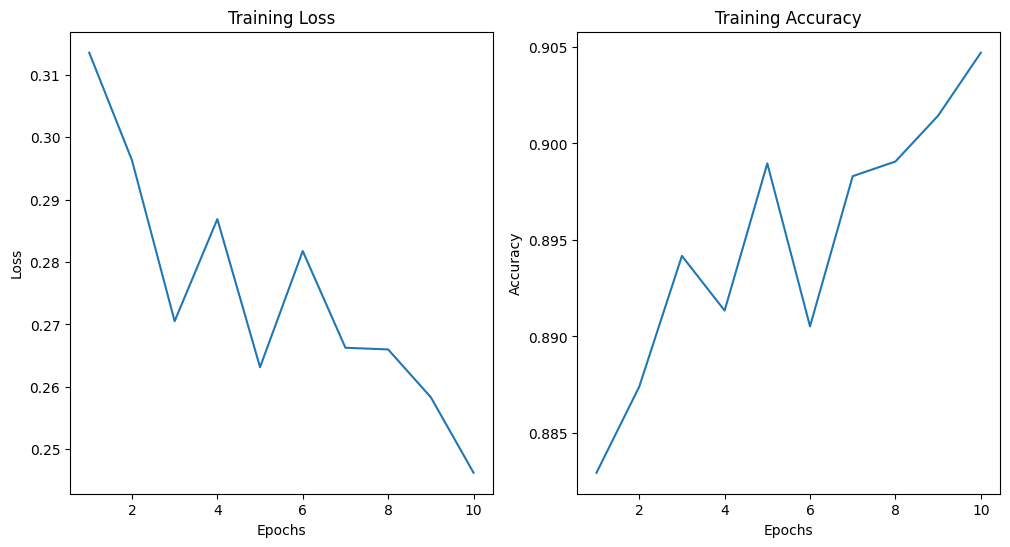

In [30]:
# Step 7: Plot Loss and Accuracy
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')

plt.show()


In [33]:
from sklearn.model_selection import train_test_split

# Step 3: Split Dataset into Train, Validation, and Test sets
def train_val_test_split(images_dir, masks_dir, test_size=0.2, val_size=0.1):
    images = os.listdir(images_dir)

    # First, split into train+val and test
    train_val_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    # Now, split train+val into train and val
    train_images, val_images = train_test_split(train_val_images, test_size=val_size, random_state=42)

    return train_images, val_images, test_images

images_dir= '/content/drive/MyDrive/Data/data/images'

masks_dir= '/content/drive/MyDrive/Data/data/labels'

# Split the dataset
train_images, val_images, test_images = train_val_test_split(images_dir, masks_dir)

# Create Datasets for train, validation, and test
train_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)
val_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)
test_dataset = TiffPngSegmentationDataset(images_dir, masks_dir, transform=transform)

# Create DataLoaders for train, validation, and test
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [34]:
# Step 6: Training and Validation Loop with Accuracy and Loss Tracking
num_epochs = 10
train_loss = []
train_accuracy = []
val_loss = []
val_accuracy = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_acc = 0.0

    # Training loop
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate metrics
        running_train_loss += loss.item()
        running_train_acc += accuracy(outputs, masks).item()

    epoch_train_loss = running_train_loss / len(train_loader)
    epoch_train_acc = running_train_acc / len(train_loader)
    train_loss.append(epoch_train_loss)
    train_accuracy.append(epoch_train_acc)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    running_val_acc = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)

            # Calculate metrics
            running_val_loss += loss.item()
            running_val_acc += accuracy(outputs, masks).item()

    epoch_val_loss = running_val_loss / len(val_loader)
    epoch_val_acc = running_val_acc / len(val_loader)
    val_loss.append(epoch_val_loss)
    val_accuracy.append(epoch_val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {epoch_train_acc:.4f}, "
          f"Val Loss: {epoch_val_loss:.4f}, Val Accuracy: {epoch_val_acc:.4f}")


Epoch [1/10], Train Loss: 0.2429, Train Accuracy: 0.9083, Val Loss: 0.2259, Val Accuracy: 0.9164
Epoch [2/10], Train Loss: 0.2452, Train Accuracy: 0.9053, Val Loss: 0.2495, Val Accuracy: 0.9153
Epoch [3/10], Train Loss: 0.2410, Train Accuracy: 0.9073, Val Loss: 0.2253, Val Accuracy: 0.9143
Epoch [4/10], Train Loss: 0.2387, Train Accuracy: 0.9053, Val Loss: 0.2174, Val Accuracy: 0.9139
Epoch [5/10], Train Loss: 0.2396, Train Accuracy: 0.9065, Val Loss: 0.2185, Val Accuracy: 0.9132
Epoch [6/10], Train Loss: 0.2544, Train Accuracy: 0.9055, Val Loss: 0.2973, Val Accuracy: 0.8851
Epoch [7/10], Train Loss: 0.2325, Train Accuracy: 0.9109, Val Loss: 0.2132, Val Accuracy: 0.9157
Epoch [8/10], Train Loss: 0.2142, Train Accuracy: 0.9145, Val Loss: 0.2975, Val Accuracy: 0.8765
Epoch [9/10], Train Loss: 0.2492, Train Accuracy: 0.9062, Val Loss: 0.2704, Val Accuracy: 0.9087
Epoch [10/10], Train Loss: 0.2453, Train Accuracy: 0.9091, Val Loss: 0.3200, Val Accuracy: 0.8745


In [35]:
# Step 7: Test Loop for Final Accuracy on the Test Set
model.eval()
running_test_acc = 0.0
with torch.no_grad():
    for images, masks in test_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        running_test_acc += accuracy(outputs, masks).item()

final_test_acc = running_test_acc / len(test_loader)
print(f"Test Accuracy: {final_test_acc:.4f}")


Test Accuracy: 0.8745


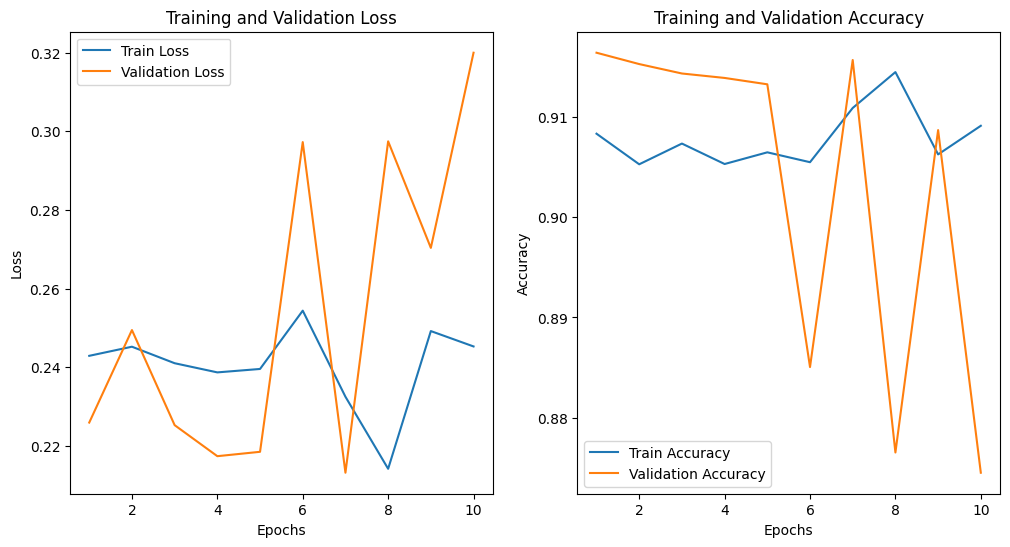

In [36]:
# Step 8: Plot Loss and Accuracy for Train and Validation
epochs_range = range(1, num_epochs + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracy, label='Train Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.show()


In [37]:
# Step 8: Save Model
model_save_path = 'unet_pretrained.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")


Model saved to unet_pretrained.pth
